# Neural Network Basics: Linear Regression with PyTorch
Date: 2020-07-01  
Author: Jason Beach  
Categories: Introduction_Tutorial, Data_Science  
Tags: pytorch, python, regression  
<!--eofm-->

In just a few short years, PyTorch took the crown for most popular deep learning framework.  Its concise and straightforward API allows for custom changes to popular networks and layers.  While some of the descriptions may some foreign to mathematicians, the concepts are familiar to anyone with a little experience in machine learning.  This post will walk the user from a simple linear regression to an (overkill) neural network model, with thousands of parameters, which provides a good base for future learning.

## Configuration

Setup our environment with the basic libraries and necessary data.

In [1]:
import numpy as np
import torch
torch.set_printoptions(edgeitems=2)

In [2]:
c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]

## Progressive Estimation

### Estimation: QR Decomposition

R is the Domain Specific Language for statistics, and we will use R's well-known `lm()` function for making initial estimates for later comparisons.  The `lm()` function uses QR decomposition for solving the normal equations for the parameters.

In [3]:
import pandas as pd
df = pd.DataFrame({'c': c, 'u': u })

In [4]:
%load_ext rpy2.ipython

               Estimate Std. Error  t value     Pr(>|t|)
(Intercept) -17.3047855  1.9272273 -8.97911 8.701879e-06
u             0.5367719  0.0355386 15.10391 1.062435e-07
[1] "MSE=2.93"


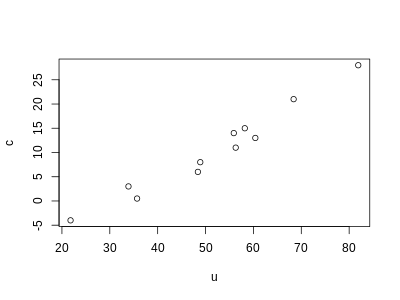

In [5]:
%%R -i df -w 400 -h 300

f <- lm(c ~ u, df)
print( summary(f)$coeff )
print( sprintf("MSE=%0.2f", mean(f$residuals^2) ))
plot(c ~ u, df)

### Prepare tensors

Lets create PyTorch tensors out of our data and create basic implementations of the model and loss functions.

In [6]:
t_c = torch.tensor(c)
t_u = torch.tensor(u)

In [7]:
def model(t_u, w, b):
    return w * t_u + b

def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

#initialize parameters
w = torch.ones(())
b = torch.zeros(())

t_p = model(t_u, w, b)
t_p

loss = loss_fn(t_p, t_c)
loss

tensor(1763.8846)

### Naive GD algorithm

The naive gradient descent algorithm displays the basic idea for updating parameter estimates over a solution surface, but this is too simple for a solution. 

In [8]:
delta = 0.1
learning_rate = 1e-2

loss_rate_of_change_w = \
    (loss_fn(model(t_u, w + delta, b), t_c) - 
     loss_fn(model(t_u, w - delta, b), t_c)) / (2.0 * delta)
w = w - learning_rate * loss_rate_of_change_w


loss_rate_of_change_b = \
    (loss_fn(model(t_u, w, b + delta), t_c) - 
     loss_fn(model(t_u, w, b - delta), t_c)) / (2.0 * delta)
b = b - learning_rate * loss_rate_of_change_b

print(w, b)

tensor(-44.1730) tensor(46.0250)


### Analytical GD method

We can create a gradient function, analytically, by taking derivates (chain rule) with respect to the parameters.  A longer derivation can be found in 'The Elements of Statistical Learning', but the gist is that updates can be done in 2 passes: 

* forward: fixed weights are used to compute predicted values
* backward: 
  - errors (delta) are computed
  - errors (s) are 'back-propogated' using the back-propogation equation
  - both delta and s errors are used to compute gradients the updates in gradient descent

In [9]:
def dloss_fn(t_p, t_c):
    dsq_diffs = 2 * (t_p - t_c) / t_p.size(0)  # <1>
    return dsq_diffs

def dmodel_dw(t_u, w, b):
    return t_u

def dmodel_db(t_u, w, b):
    return 1.0

def grad_fn(t_u, t_c, t_p, w, b):
    dloss_dtp = dloss_fn(t_p, t_c)
    dloss_dw = dloss_dtp * dmodel_dw(t_u, w, b)
    dloss_db = dloss_dtp * dmodel_db(t_u, w, b)
    return torch.stack([dloss_dw.sum(), dloss_db.sum()])  # <1>

In [10]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c, print_params=True):
    for epoch in range(1, n_epochs + 1):
        w, b = params

        t_p = model(t_u, w, b)                 #Forward Pass (prediction)
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b)    #Backward Pass (compute gradient)

        params = params - learning_rate * grad

        if epoch in {1, 2, 3, 10, 11, 99, 100, 4000, 5000}:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            if print_params:
                print('    Params:', params)
                print('    Grad:  ', grad)
        if epoch in {4, 12, 101}:
            print('...')

        if not torch.isfinite(loss).all():     #check for divergence (updates are too large)
            break 
            
    return params

Fix divergence with different approaches, including:

* ensure similar parameters (normalize input columns)
* adaptive learning rate

In [11]:
t_un = 0.1 * t_u

In [12]:
params = training_loop(
    n_epochs = 5000, 
    learning_rate = 1e-2, 
    params = torch.tensor([1.0, 0.0]), 
    t_u = t_un, 
    t_c = t_c,
    print_params = False)

params

Epoch 1, Loss 80.364342
Epoch 2, Loss 37.574917
Epoch 3, Loss 30.871077
...
Epoch 10, Loss 29.030487
Epoch 11, Loss 28.941875
...
Epoch 99, Loss 22.214186
Epoch 100, Loss 22.148710
...
Epoch 4000, Loss 2.927680
Epoch 5000, Loss 2.927648


tensor([  5.3671, -17.3012])

## PyTorch Components

The PyTorch API is well designed, but there are many assumptions incorporated into the functionality.  Be sure you know these basics, thoroughly.

### Using autograd

Back-propagation: we computed the gradient of a composition of functions - the model and the loss - with respect to their inner-most parameters - w and b - by propagating derivatives backwards using the chain rule.

Given a forward expression, no matter how nested, PyTorch will provide the gradient of that expression with respect to its input parameters automatically.  This is because PyTorch tensors can remember where they come from, in terms of the operations and parent tensors that originated them, and they can provide the chain of derivatives of such operations with respect to their inputs automatically.

In [14]:
def model(t_u, w, b):
    return w * t_u + b

def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

params = torch.tensor([1.0, 0.0], requires_grad=True)
params.grad is None

True

That argument `requires_grad=True` is telling PyTorch to track the entire family tree of tensors resulting from operations on params. In other words, any tensor that will have params as an ancestor will have access to the chain of functions that were called to get from params to that tensor. In case these functions are differentiable (and most PyTorch tensor operations will be), the value of the derivative will be automatically populated as a grad attribute of the params tensor.

All we have to do to populate it is to start with a tensor with requires_grad set to True, then call the model (predict new values), compute the loss, and then call backward on the loss tensor.  The grad attribute of params contains the derivatives of the loss with respect to each element of params.

In [15]:
loss = loss_fn(model(t_u, *params), t_c)
loss.backward()
params.grad

tensor([4517.2969,   82.6000])

__WARNING:__ Calling backward will lead derivatives to accumulate (summed) at leaf nodes. We need to zero the gradient explicitly after using it for parameter updates.

In [16]:
if params.grad is not None:
    params.grad.zero_()
params.grad

tensor([0., 0.])

The logic inside the `with` statement will be used with an 'optimizer'.

In [17]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        if params.grad is not None:     #call prior to loss.backward()
            params.grad.zero_()
        
        t_p = model(t_u, *params) 
        loss = loss_fn(t_p, t_c)
        loss.backward()
        
        with torch.no_grad():          #autograd mechanism should not add edges to the forward graph 
            params -= learning_rate * params.grad        #keep the same tensor params around, but subtract our update from it

        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            
    return params

In [18]:
training_loop(
    n_epochs = 5000,
    learning_rate = 1e-2,
    params = torch.tensor([1.0, 0.0], requires_grad=True),
    t_u = t_un,
    t_c = t_c)

Epoch 500, Loss 7.860116
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957697
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)

### Selecting an optimizer

In [19]:
import torch.optim as optim

dir(optim)[:10]

['ASGD',
 'Adadelta',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'Optimizer',
 'RMSprop',
 'Rprop']

The optimizer is used with four basic steps:

* optimizer holds a reference to parameters, and
* after a loss is computed from inputs
* a call to `.backward()` leads to `.grad()` being populated on parameters, then
* the optimizer can access `.grad()` and compute the parameter updates

The optimizer exposes two methods: 

* `.zero_grad()` - zeroes the grad attribute of all the parameters passed to the optimizer 
* `.step()` - updates the value of those parameters according to the specific optimization strategy

In [20]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-5
optimizer = optim.SGD([params], lr=learning_rate)

In [22]:
#complete step
t_p = model(t_un, *params)
loss = loss_fn(t_p, t_c)
optimizer.zero_grad()    #must zero-out params
loss.backward()
optimizer.step()
params

tensor([1.0008e+00, 1.0640e-04], requires_grad=True)

In [23]:
def training_loop(n_epochs, optimizer, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
    return params

In [24]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)    #same params

training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    params = params,        #same params
    t_u = t_un,
    t_c = t_c)

Epoch 500, Loss 7.860118
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957697
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927680
Epoch 4500, Loss 2.927651
Epoch 5000, Loss 2.927648


tensor([  5.3671, -17.3012], requires_grad=True)

### Choosing activation functions

A neural network is actually just a polynomial function with 'activation' functions around the nested terms.  This small list of activation functions gives an idea of the most useful properties.  While sigmoid was the most orthodox, originally, Rectified Linear Units (ReLU) are shown to be better.

In [85]:
import numpy as np
import matplotlib.pyplot as plt

In [82]:
input_t = torch.arange(-3, 3.1, 0.1)

In [83]:
activation_list = [
    nn.Tanh(),
    nn.Hardtanh(),
    nn.Sigmoid(),
    
    nn.Softplus(),
    nn.ReLU(),
    nn.LeakyReLU(negative_slope=0.1),

    #nn.Tanhshrink(),
    #nn.Softshrink(),
    #nn.Hardshrink(),
]

tensor([-0.3000, -0.2900, -0.2800, -0.2700, -0.2600, -0.2500, -0.2400, -0.2300,
        -0.2200, -0.2100, -0.2000, -0.1900, -0.1800, -0.1700, -0.1600, -0.1500,
        -0.1400, -0.1300, -0.1200, -0.1100, -0.1000, -0.0900, -0.0800, -0.0700,
        -0.0600, -0.0500, -0.0400, -0.0300, -0.0200, -0.0100,  0.0000,  0.1000,
         0.2000,  0.3000,  0.4000,  0.5000,  0.6000,  0.7000,  0.8000,  0.9000,
         1.0000,  1.1000,  1.2000,  1.3000,  1.4000,  1.5000,  1.6000,  1.7000,
         1.8000,  1.9000,  2.0000,  2.1000,  2.2000,  2.3000,  2.4000,  2.5000,
         2.6000,  2.7000,  2.8000,  2.9000,  3.0000])

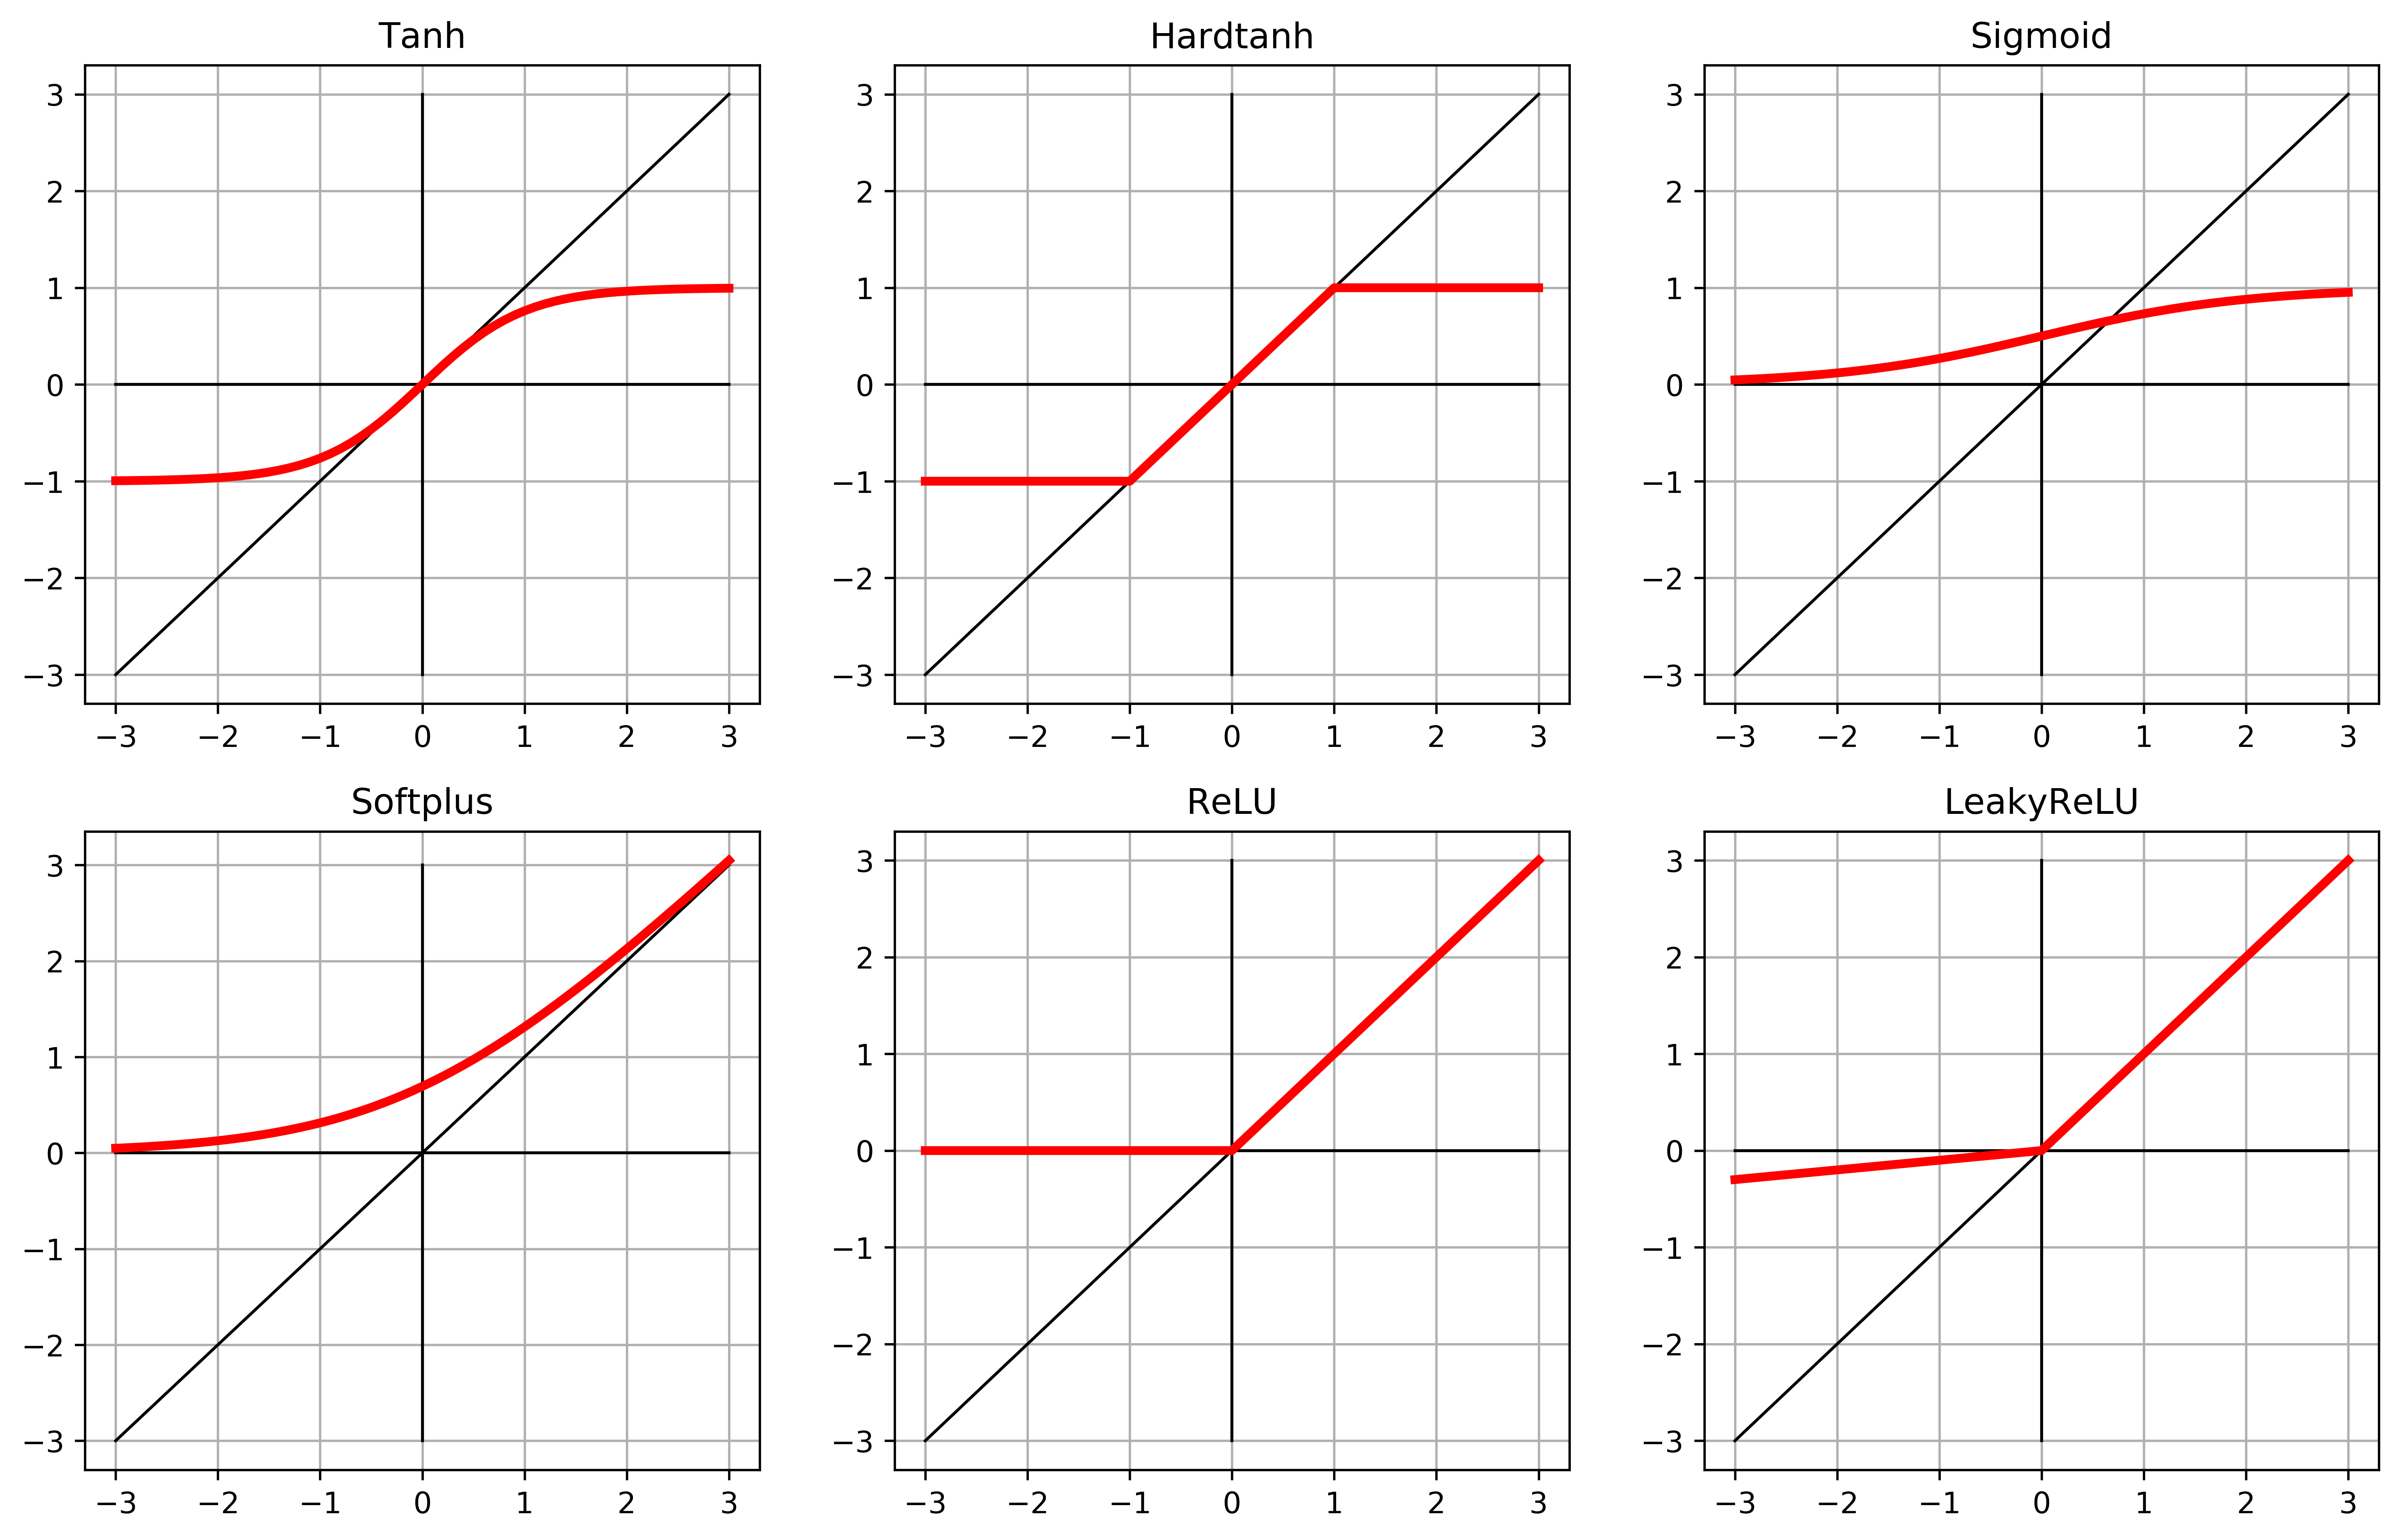

In [86]:
fig = plt.figure(figsize=(14, 28), dpi=600)

for i, activation_func in enumerate(activation_list):
    subplot = fig.add_subplot(len(activation_list), 3, i+1)
    subplot.set_title(type(activation_func).__name__)
    
    output_t = activation_func(input_t)
    
    plt.grid()
    plt.plot(input_t.numpy(), input_t.numpy(),'k', linewidth=1)
    plt.plot([-3,3], [0,0], 'k', linewidth=1)
    plt.plot([0,0], [-3,3], 'k', linewidth=1)
    plt.plot(input_t.numpy(), output_t.numpy(), 'r', linewidth=3)

output_t

### Preparing the training-validation split

The first line in the training loop evaluates model on `train_t_u` to produce `train_t_p`. Then `train_loss` is evaluated from `train_t_p`. This creates a computation graph that links `train_t_u` to `train_t_p` to `train_loss`. When model is evaluated again on `val_t_u`, it produces `val_t_p` and `val_loss`. In this case, a separate
 computation graph will be created that links `val_t_u` to `val_t_p` to `val_loss`. Separate tensors have been run through the same functions, `model()` and `loss_fn()`, generating separate computation graphs.
 
Since we’re never calling `backward()` on `val_loss`, why are we building the graph in the first place? We could in fact just call `model()` and `loss_fn()` as plain functions, without tracking history. However optimized, tracking history comes with additional costs that we could totally forego during the validation pass, especially when the model has millions of parameters.  In order to address this, PyTorch allows us to __switch off autograd__ when we don’t need it using the `torch.no_grad` context manager. 

In [57]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([ 8,  5, 10,  0,  1,  6,  3,  2,  7]), tensor([4, 9]))

In [58]:
train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]

val_t_u = t_u[val_indices]
val_t_c = t_c[val_indices]

train_t_un = 0.1 * train_t_u
val_t_un = 0.1 * val_t_u

In [27]:
def training_loop(n_epochs, optimizer, params, train_t_u, val_t_u, train_t_c, val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_t_u, *params)       #training data
        train_loss = loss_fn(train_t_p, train_t_c)
                             
        with torch.no_grad():                       #switch-off autograd when we don’t need it                         
            val_t_p = model(val_t_u, *params)       #validation data, separate computation graph will be created
            val_loss = loss_fn(val_t_p, val_t_c)
            assert val_loss.requires_grad == False  #ensure autograd is off
        
        optimizer.zero_grad()
        train_loss.backward()          #backward only called on train_loss: accumulated the derivatives on the leaf nodes
        optimizer.step()

        if epoch <= 3 or epoch % 500 == 0:
            print('Epoch {}, Training loss {}, Validation loss {}'.format(
                epoch, float(train_loss), float(val_loss)))
            
    return params

In [28]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    params = params,
    train_t_u = train_t_un,        #training dependent var
    val_t_u = val_t_un,            #validation dependent var 
    train_t_c = train_t_c,
    val_t_c = val_t_c)

Epoch 1, Training loss 93.96257781982422, Validation loss 19.172250747680664
Epoch 2, Training loss 30.066646575927734, Validation loss 43.27933120727539
Epoch 3, Training loss 24.354103088378906, Validation loss 53.700531005859375
Epoch 500, Training loss 11.108868598937988, Validation loss 12.03146743774414
Epoch 1000, Training loss 5.690493106842041, Validation loss 0.8163924217224121
Epoch 1500, Training loss 3.397932529449463, Validation loss 1.738821268081665
Epoch 2000, Training loss 2.4279325008392334, Validation loss 5.815708160400391
Epoch 2500, Training loss 2.017514944076538, Validation loss 9.938664436340332
Epoch 3000, Training loss 1.843862771987915, Validation loss 13.242980003356934


tensor([  5.8612, -20.4629], requires_grad=True)

Our main goal is to also see both the training loss and the validation loss decreasing. While ideally both losses would be rougly the same value, as long as validation loss stays reasonably close to the training loss, we know that our model is continuing to learn generalized things about our data. 

## Working with Layers (nn.Module)

A PyTorch module is a Python class deriving from the `nn.Module` base class. A Module can have one or more `Parameter` instances as attributes, which are tensors whose values are optimized during the training process (think w and b in our linear model). A Module can also have one or more submodules (subclasses of `nn.Module`) as attributes, and it will be able to track their Parameters as well.

NOTE
The submodules must be top-level attributes, not buried inside list or dict instances! Otherwise the optimizer will not be able to locate the submodules (and hence their parameters). For situations where your model requires a list or dict of submodules, PyTorch provides `nn.ModuleList` and `nn.ModuleDict`.

All PyTorch-provided subclasses of `nn.Module` have their `__call__` method defined. This allows one to instantiate an `nn.Linear` and call it as if it was a function, like so:

In [48]:
c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]

In [49]:
t_c = torch.tensor(c).unsqueeze(1)     #add an extra dimension for batch
t_u = torch.tensor(u).unsqueeze(1)     #same
t_c[:3]

tensor([[ 0.5000],
        [14.0000],
        [15.0000]])

In [50]:
import torch.nn as nn
linear_model = nn.Linear(1, 1)     #args: input size, output size, and bias defaulting to True.
linear_model(t_c[:3])

tensor([[-0.8724],
        [-4.6115],
        [-4.8885]], grad_fn=<AddmmBackward>)

Calling an instance of `nn.Module` with a set of arguments ends up calling a method named forward with the same arguments. The forward method is what executes the forward computation, while `__call__` does other rather important chores before and after calling forward. So, it is technically possible to call forward directly and it will produce the same output as `__call__`, but it should not be done from user code:

In [ ]:
y = model(x)              #correct
y = model.forward(x)      #don't do this

In [51]:
linear_model.weight, linear_model.bias

(Parameter containing:
 tensor([[-0.2770]], requires_grad=True), Parameter containing:
 tensor([-0.7339], requires_grad=True))

Any module in `nn` is written to produce outputs for a batch of multiple inputs at the same time.  Modules expect the zeroth dimension of the input to be the number of samples in the batch. 

In [54]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val, t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train)        #add model as an input
        loss_train = loss_fn(t_p_train, t_c_train)
        t_p_val = model(t_u_val)
        loss_val = loss_fn(t_p_val, t_c_val)
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        if epoch == 1 or epoch % 1000 == 0:
            print('Epoch {}, Training loss {}, Validation loss {}'.format(
                epoch, float(loss_train), float(loss_val)))

In [59]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(
    linear_model.parameters(),    #replaced [params] with this method call 
    lr=1e-2)
training_loop(
    n_epochs = 3000,
    optimizer = optimizer,
    model = linear_model,
    loss_fn = nn.MSELoss(),
    t_u_train = train_t_un,
    t_u_val = val_t_un,
    t_c_train = train_t_c,
    t_c_val = val_t_c)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 184.62193298339844, Validation loss 131.338623046875
Epoch 1000, Training loss 2.996669054031372, Validation loss 6.098757266998291
Epoch 2000, Training loss 2.4377217292785645, Validation loss 6.508167743682861
Epoch 3000, Training loss 2.4287760257720947, Validation loss 6.561643123626709

Parameter containing:
tensor([[5.4813]], requires_grad=True)
Parameter containing:
tensor([-17.4250], requires_grad=True)


## Create a NeuralNetwork

### Simple models

Let’s build the simplest possible neural network: a linear module, followed by an activation function, feeding into another linear module. The first linear + activation layer is commonly referred to as a __hidden layer__ for historical reasons, since its outputs are not observed directly but fed into the output layer. 

In [61]:
seq_model = nn.Sequential(
    nn.Linear(1, 13),
    nn.Tanh(),
    nn.Linear(13, 1))

After calling model.backward() all parameters will be populated with their grad and the optimizer will then update their value accordingly during the optimizer.step() call. 

In [64]:
[print(param.shape) for param in seq_model.parameters()]

print()
for name, param in seq_model.named_parameters():
    print(name, param.shape)

torch.Size([13, 1])
torch.Size([13])
torch.Size([1, 13])
torch.Size([1])

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [78]:
from collections import OrderedDict
namedseq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 13)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(13, 1))
]))
namedseq_model.output_linear.bias

Parameter containing:
tensor([-0.1054], requires_grad=True)

In [70]:
optimizer = optim.SGD(
    seq_model.parameters(), 
    lr=1e-3)

training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = train_t_un,
    t_u_val = val_t_un,
    t_c_train = train_t_c,
    t_c_val = val_t_c)

print()
print('output', seq_model(val_t_un))
print('answer', val_t_c)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training loss 1.2322325706481934, Validation loss 7.267159461975098
Epoch 1000, Training loss 1.2229273319244385, Validation loss 7.296848773956299
Epoch 2000, Training loss 1.2134442329406738, Validation loss 7.330402374267578
Epoch 3000, Training loss 1.2036887407302856, Validation loss 7.36702823638916
Epoch 4000, Training loss 1.193618655204773, Validation loss 7.405879974365234
Epoch 5000, Training loss 1.1832159757614136, Validation loss 7.446534156799316

output tensor([[13.1834],
        [16.1821]], grad_fn=<AddmmBackward>)
answer tensor([[11.],
        [13.]])
hidden tensor([[ 0.0005],
        [-0.0007],
        [ 0.0138],
        [ 0.0057],
        [-0.0029],
        [ 0.0027],
        [ 0.0025],
        [-0.0165],
        [ 0.0027],
        [-0.0030],
        [-0.0018],
        [ 0.0017],
        [-0.0152]])


### Subclassing the `nn.Module`

In order to subclass nn.Module, at a minimum we need to define a .forward(...) function that takes the input to the module and returns the output. If we use standard torch operations, autograd will take care of the backward pass automatically.  Often your entire model will be implemented as a subclass of nn.Module, which can, in turn, contain submodules that are also subclasses of nn.Module.

Assigning an instance of nn.Module to an attribute in a nn.Module, just like we did in the constructor here, automatically registers the module as a submodule. This allows modules to have access to the parameters of its submodules without further action by the user.

In [71]:
class SubclassModel(nn.Module):
    def __init__(self):
        super().__init__()        #calls nn.Module 's __init__ which sets up the housekeeping
        self.hidden_linear = nn.Linear(1, 13)
        self.hidden_activation = nn.Tanh()
        self.output_linear = nn.Linear(13, 1)
    def forward(self, input):
        hidden_t = self.hidden_linear(input)
        activated_t = self.hidden_activation(hidden_t)
        output_t = self.output_linear(activated_t)
        return output_t
    
subclass_model = SubclassModel()
subclass_model

SubclassModel(
  (hidden_linear): Linear(in_features=1, out_features=13, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=13, out_features=1, bias=True)
)

In [79]:
for type_str, model in [('seq', seq_model), ('namedseq', namedseq_model), ('subclass', subclass_model)]:
    print(type_str)
    for name_str, param in model.named_parameters():
        print("{:21} {:19} {}".format(name_str, str(param.shape), param.numel()))
    print()

seq
hidden_linear.weight  torch.Size([13, 1]) 13
hidden_linear.bias    torch.Size([13])    13
output_linear.weight  torch.Size([1, 13]) 13
output_linear.bias    torch.Size([1])     1

namedseq
hidden_linear.weight  torch.Size([13, 1]) 13
hidden_linear.bias    torch.Size([13])    13
output_linear.weight  torch.Size([1, 13]) 13
output_linear.bias    torch.Size([1])     1

subclass
hidden_linear.weight  torch.Size([13, 1]) 13
hidden_linear.bias    torch.Size([13])    13
output_linear.weight  torch.Size([1, 13]) 13
output_linear.bias    torch.Size([1])     1



### Using the functional API

`torch.nn.functional` provides the many of the same modules we find in nn, but with all eventual parameters moved as an argument to the function call.  By "functional" here we mean "having no internal state", or, in other words, "whose output value is solely and fully determined by the value input arguments".  The functional counterpart of `nn.Linear` is `nn.functional.linear`.

A Module is a container for state in forms of Parameters and submodules combined with the instructions to do a forward.

In [80]:
class SubclassFunctionalModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_linear = nn.Linear(1, 14)
        self.output_linear = nn.Linear(14, 1)
    def forward(self, input):
        hidden_t = self.hidden_linear(input)
        activated_t = torch.tanh(hidden_t)       #use functional form, no state is needed
        output_t = self.output_linear(activated_t)
        return output_t
    
func_model = SubclassFunctionalModel()
func_model

SubclassFunctionalModel(
  (hidden_linear): Linear(in_features=1, out_features=14, bias=True)
  (output_linear): Linear(in_features=14, out_features=1, bias=True)
)

In [81]:
optimizer = optim.SGD(
    func_model.parameters(), 
    lr=1e-3)

training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    model = func_model,
    loss_fn = nn.MSELoss(),
    t_u_train = train_t_un,
    t_u_val = val_t_un,
    t_c_train = train_t_c,
    t_c_val = val_t_c)

print()
print('output', seq_model(val_t_un))
print('answer', val_t_c)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training loss 179.48944091796875, Validation loss 125.14144897460938
Epoch 1000, Training loss 2.4361188411712646, Validation loss 9.148082733154297
Epoch 2000, Training loss 1.422125220298767, Validation loss 7.820898532867432
Epoch 3000, Training loss 1.3350441455841064, Validation loss 7.297579765319824
Epoch 4000, Training loss 1.3103053569793701, Validation loss 7.1512041091918945
Epoch 5000, Training loss 1.2794909477233887, Validation loss 7.114054203033447

output tensor([[13.1834],
        [16.1821]], grad_fn=<AddmmBackward>)
answer tensor([[11.],
        [13.]])
hidden tensor([[ 0.0005],
        [-0.0007],
        [ 0.0138],
        [ 0.0057],
        [-0.0029],
        [ 0.0027],
        [ 0.0025],
        [-0.0165],
        [ 0.0027],
        [-0.0030],
        [-0.0018],
        [ 0.0017],
        [-0.0152]])


## Conclusion

This post describes the fundamentals of PyTorch neural networks as they are applied to a simple linear regression.  Because of implicit aspects of this functionality, these must be understood before trying more challenging problems.